# Define the system  

In [9]:
import numpy as np
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
from qubols.mixed_solution_vector import MixedSolutionVector_V2 as MixedSolutionVector
from qubols.encodings import  RangedEfficientEncoding, PositiveQbitEncoding


nqbit = 5
range = (4/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=0.25, offset=-4, var_base_name="x")
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=0.25, offset=-4, var_base_name="x")


nqbit = 8
flow_encoding = RangedEfficientEncoding(nqbit=nqbit, range=5., offset=+0.0, var_base_name="x")
head_encoding = RangedEfficientEncoding(nqbit=nqbit, range=5, offset=+0.0, var_base_name="x")

np.sort(flow_encoding.get_possible_values())


array([-5.03937008, -5.        , -4.96062992, -4.92125984, -4.88188976,
       -4.84251969, -4.80314961, -4.76377953, -4.72440945, -4.68503937,
       -4.64566929, -4.60629921, -4.56692913, -4.52755906, -4.48818898,
       -4.4488189 , -4.40944882, -4.37007874, -4.33070866, -4.29133858,
       -4.2519685 , -4.21259843, -4.17322835, -4.13385827, -4.09448819,
       -4.05511811, -4.01574803, -3.97637795, -3.93700787, -3.8976378 ,
       -3.85826772, -3.81889764, -3.77952756, -3.74015748, -3.7007874 ,
       -3.66141732, -3.62204724, -3.58267717, -3.54330709, -3.50393701,
       -3.46456693, -3.42519685, -3.38582677, -3.34645669, -3.30708661,
       -3.26771654, -3.22834646, -3.18897638, -3.1496063 , -3.11023622,
       -3.07086614, -3.03149606, -2.99212598, -2.95275591, -2.91338583,
       -2.87401575, -2.83464567, -2.79527559, -2.75590551, -2.71653543,
       -2.67716535, -2.63779528, -2.5984252 , -2.55905512, -2.51968504,
       -2.48031496, -2.44094488, -2.4015748 , -2.36220472, -2.32

In [10]:
sv1 = SolutionVector(1, encoding=flow_encoding)
sv2 = SolutionVector(1, encoding=head_encoding)

msv = MixedSolutionVector([sv1,sv2])

In [11]:
import numpy as np
A = np.array([
    [1,   1,],
    [ 1,  2,],
])
b = np.array([1,-2]).reshape(-1,1)
ref_sol = np.linalg.solve(A, b).reshape(-1)
ref_sol

array([ 4., -3.])

In [12]:
from qubols.qubo_poly_mixed_variables import QUBO_POLY
import sparse 
from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import TabuSampler
from dimod import ExactSolver

# sampler = TabuSampler()
sampler = SimulatedAnnealingSampler()
# sampler = ExactSolver() 


qubo = QUBO_POLY(msv, options={"sampler" : sampler} )
matrices = tuple(sparse.COO(m) for m in [-1*b, A])

bqm = qubo.create_bqm(matrices, strength=1E3)

# sample
sampleset = qubo.sample_bqm(bqm, num_reads=10000)

# decode
sol  = qubo.decode_solution(sampleset.lowest().record[0][0])
sol = np.array(sol[0]+sol[1])

data_ref, eref = qubo.compute_energy(ref_sol, bqm)
data_sol, esol = qubo.compute_energy(sol, bqm)

print('ref: ', ref_sol, '->', data_ref[0], ' energy: ', eref)
print('sol: ', sol, '->', data_sol[0], ' energy: ', esol)
print(ref_sol - sol)


ref:  [ 4. -3.] -> [4.015748031496063, -2.992125984251969]  energy:  -4.998449996899992
sol:  [ 3.97637795 -2.99212598] -> [3.9763779527559056, -2.992125984251969]  energy:  -4.999689999380009
[ 0.02362205 -0.00787402]


In [53]:
bqm.variables

Variables(['x_001_001', 'x_001_002', 'x_001_003', 'x_001_004', 'x_001_005', 'x_001_006', 'x_001_007', 'x_002_001', 'x_002_002', 'x_002_003', 'x_002_004', 'x_002_005', 'x_002_006', 'x_002_007', 'x_003_001', 'x_003_002', 'x_003_003', 'x_003_004', 'x_003_005', 'x_003_006', 'x_003_007', 'x_004_001', 'x_004_002', 'x_004_003', 'x_004_004', 'x_004_005', 'x_004_006', 'x_004_007'])

In [54]:
net.verify_solution(sol)

NameError: name 'net' is not defined

In [ ]:
import itertools
def find_closest(encoding, float):
    """get all the posible values encoded

    Returns:
        _type_: _description_
    """

    min_diff = 1E12
    closest_value = None 
    binary_encoding = None
    for data in itertools.product([0, 1], repeat=encoding.nqbit):
        val = encoding.decode_polynom(list(data)[::-1])
        if np.abs(val-float) < min_diff:
            min_diff  = np.abs(val-float)
            closest_value = val 
            binary_encoding = list(data)[::-1]

    return closest_value, binary_encoding 
vmin, bins = find_closest(flow_encoding, 2.)
vmin
bins

[1, 1, 1]

In [ ]:
var = sampleset.lowest().variables
data = np.array(sampleset.lowest().record[0][0])
data_real_var = data[qubo.index_variables]

for v, d in zip(var, data):
    if v not in qubo.mapped_variables:
        x0, x1 = v.split('*')
        i0 = qubo.index_variables[qubo.mapped_variables.index(x0)]
        i1 = qubo.index_variables[qubo.mapped_variables.index(x1)]
        assert(d == data[i0] * data[i1])

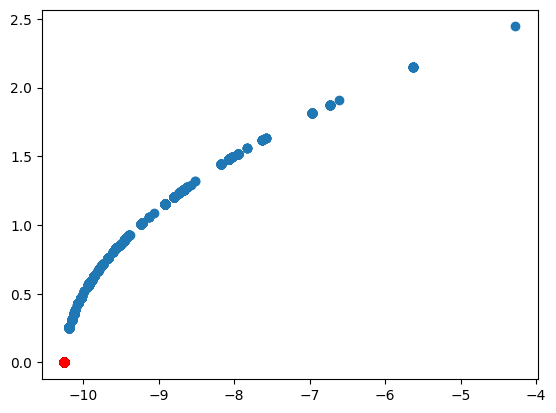

In [ ]:
import matplotlib.pyplot as plt
energy = []
residue = []
for s in sampleset.record:
    energy.append(s[1])
    sol = qubo.decode_solution(s[0])
    r = net.verify_solution(np.array(sol).reshape(-1,))
    residue.append(np.linalg.norm(r))
plt.scatter(energy, (residue))

el, rl = [], []
for s in sampleset.lowest().record:
    el.append(s[1])
    sol = qubo.decode_solution(s[0])
    r = net.verify_solution(np.array(sol).reshape(-1,))
    rl.append(np.linalg.norm(r+1E-12))
plt.scatter(el, rl, c='red')

In [ ]:
from qubols.qubo_poly import QUBO_POLY
from qubols.solution_vector import SolutionVector_V2 as SolutionVector
import sparse 
from dwave.samplers import SimulatedAnnealingSampler
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import TabuSampler

encoding = RangedEfficientEncoding(nqbit=12, range=2.0, offset=0.0, var_base_name="x")
sol_vec = SolutionVector(4, encoding)

qubo = QUBO_POLY(solution_vector=sol_vec, options={ 'num_reads':1000, 'sampler':SimulatedAnnealingSampler()})
matrices = tuple(sparse.COO(m) for m in net.matrices)

bqm = qubo.create_bqm(matrices, strength=10000)

# sample
sampleset = qubo.sample_bqm(bqm, num_reads=5000)

# decode
sol  = qubo.decode_solution(sampleset.lowest().record[0][0])
sol = np.array(sol).reshape(-1)
print(ref_sol)
print(sol)
print(ref_sol - sol)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7d385c05bac0>>
Traceback (most recent call last):
  File "/home/nico/miniconda3/envs/vitens_wntr_1/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
